# 把之前在nn上部署的最好的模型从底层开始实现一遍

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import os
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

### 加载数据

In [2]:
mydir = os.getcwd() + '\\data01'

# 读取本地文件
train_features = torch.load('{}/train_features.pt'.format(mydir))
test_features = torch.load('{}/test_features.pt'.format(mydir))
train_labels = torch.load('{}/train_labels.pt'.format(mydir))
test_data = pd.read_csv('{}/test_data.csv'.format(mydir))

#### 定义网络

In [3]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

def relu(X):  #@save
    """ReLU激活函数。"""
    constant_zero = torch.zeros_like(X)
    return torch.max(X, constant_zero)

def mlp(X, w1 ,b1, w2, b2):  #@save
    """定义网络模型"""
    X = X.reshape((-1, w1.shape[0]))
    H = relu(linreg(X, w1, b1))
    return linreg(H, w2, b2)

# 不能使用nn.Moudle，自己重写模型
class MLP:
    def __init__(self,input_dim, hidden_dim, output_dim):
        super().__init__()
        self.w1 = nn.Parameter(torch.normal(0, 0.01, size=(input_dim, hidden_dim), requires_grad=True))
        self.b1 = nn.Parameter(torch.zeros(hidden_dim, requires_grad=True))
        self.w2 = nn.Parameter(torch.normal(0, 0.01, size=(hidden_dim, output_dim), requires_grad=True))
        self.b2 = nn.Parameter(torch.zeros(output_dim, requires_grad=True))
        self.params = [self.w1, self.b1, self.w2, self.b2]
        # 保存初始化的参数
        torch.save(self.params, '{}/params.pt'.format(mydir))
        
        
    def forward(self, X):
        return mlp(X, self.w1, self.b1, self.w2, self.b2)
    
    def reset_parameters(self):
        self.params = torch.load('{}/params.pt'.format(mydir))
        self.w1 = self.params[0]
        self.b1 = self.params[1]
        self.w2 = self.params[2]
        self.b2 = self.params[3]


#### 定义损失函数

In [4]:
def squared_loss(preds, labels): 
    """均方损失。"""
    return (preds - labels.reshape(preds.shape)) ** 2

def log_rmse(preds, labels): 
    """对数均方根误差。"""
    return squared_loss(torch.log(preds+1), torch.log(labels+1)).mean()

#### 定义优化器

In [5]:
def sgd(params, lr): 
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

#### 超参数

In [6]:
learning_rate = 0.01
batch_size = 16
num_epochs = 50
loss_fn = log_rmse
optimizer = sgd

input_dim = train_features.shape[1]
hidden_dim = 400
output_dim = 1
model = MLP(input_dim, hidden_dim, output_dim)


#### 制作mini-batch的data loader

In [7]:
# 借鉴老师ppt中的代码
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [8]:
for X, y in data_iter(batch_size, train_features, train_labels):
    print("X.shape", X.shape,"y.shape", y.shape)
    output = model.forward(X)
    print("output.shape", output.shape)
    break

X.shape torch.Size([16, 331]) y.shape torch.Size([16, 1])
output.shape torch.Size([16, 1])


#### 简单训练

In [9]:
# model.reset_parameters()
# learning_rate = 20
# history = []
# for epoch in range(100):
#     train_loss = 0
#     for X, y in data_iter(batch_size, train_features, train_labels):
#         output = model.forward(X)
#         loss = loss_fn(output, y)
#         loss.backward()
#         optimizer(model.params, learning_rate)
#         train_loss += loss.item() * X.shape[0]

#     train_loss /= len(train_features)
#     history.append(train_loss)
#     if (epoch + 1) % 20 == 0:
#         print('epoch %d, train loss %f' % (epoch + 1, train_loss))

# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(history) + 1), history)
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

In [10]:
# # 现在不进行参数初始化，直接使用上一次的参数
# learning_rate = 10
# for epoch in range(100):
#     train_loss = 0
#     # learning_rate = learning_rate * 0.95
#     for X, y in data_iter(batch_size, train_features, train_labels):
#         output = model.forward(X)
#         loss = loss_fn(output, y)
#         loss.backward()
#         optimizer(model.params, learning_rate)
#         train_loss += loss.item() * X.shape[0]
#     train_loss /= len(train_features)
#     if (epoch + 1) % 10 == 0:
#         print('epoch %d, train loss %f' % (epoch + 1, train_loss))

#### Kfold调参

In [11]:
learning_rate = 10
batch_size = 16
num_epochs = 100
loss_fn = log_rmse
optimizer = sgd

input_dim = train_features.shape[1]
hidden_dim = 400
output_dim = 1
model = MLP(input_dim, hidden_dim, output_dim)

In [12]:
n_splits=5 # 子集个数
is_print=True
print_every=20
X = train_features
y = train_labels

kf = KFold(n_splits=n_splits) # 创建KFold对象

train_losses_per_fold = [] # 记录每个fold的训练损失
test_losses_per_fold = [] # 记录每个fold的测试损失
mean_train_losses = np.zeros(num_epochs) # 记录每个epoch的平均训练损失
mean_test_losses = np.zeros(num_epochs) # 记录每个epoch的平均测试损失

# 开始交叉验证循环
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    if is_print:
        print(f"Fold {fold_index}")

    model.reset_parameters() # 重置模型参数

    X_train = X[train_index] # 训练集特征
    y_train = y[train_index] # 训练集标签
    X_test = X[test_index] # 验证集特征
    y_test = y[test_index] # 验证集标签

    train_loss_history = [] # 记录训练损失
    test_loss_history = [] # 记录测试损失

    for epoch in range(num_epochs): # 训练num_epochs个周期

        train_loss = 0
        test_loss = 0
        
        with torch.no_grad(): 
            
            for batch_X, batch_y in data_iter(batch_size, X_test, y_test): 
                
                output = model.forward(batch_X).squeeze() # 前向传播，得到输出
                
                loss = loss_fn(output, batch_y.float())

                test_loss += loss.item() * batch_y.shape[0] # 记录测试损失
        

        for batch_X, batch_y in data_iter(batch_size, X_train, y_train): # 遍历训练集批次
            
            # optimizer.zero_grad() # 清空梯度
            
            output = model.forward(batch_X).squeeze() # 前向传播，得到输出
            
            loss = loss_fn(output, batch_y.float()) # 计算损失
            
            loss.backward() # 反向传播，计算梯度
            
            optimizer(model.params, learning_rate) # 更新参数

            train_loss += loss.item() * batch_y.shape[0] # 记录训练损失

        mean_train_loss = train_loss / X_train.shape[0] # 计算平均训练损失
        mean_test_loss = test_loss / X_test.shape[0]# 计算平均测试损失
        
        if is_print and (epoch+1) % print_every == 0: # 每print_every个周期打印一次训练信息(损失
            print(f"Epoch | {epoch+1:2d}/{num_epochs:2d} | Train Loss: {mean_train_loss:.4f} | Test Loss: {mean_test_loss:.4f}")

        train_loss_history.append(mean_train_loss) # 记录训练损失
        test_loss_history.append(mean_test_loss) # 记录测试损失

    train_losses_per_fold.append(train_loss_history) # 记录每个fold的训练损失
    test_losses_per_fold.append(test_loss_history) # 记录每个fold的测试损失

mean_train_losses = np.mean(np.array(train_losses_per_fold), axis=0)
mean_test_losses = np.mean(np.array(test_losses_per_fold), axis=0)

Fold 0
Epoch | 20/100 | Train Loss: 0.0754 | Test Loss: 0.0694
Epoch | 40/100 | Train Loss: 0.0520 | Test Loss: 0.0451
Epoch | 60/100 | Train Loss: 0.0430 | Test Loss: 0.0366
Epoch | 80/100 | Train Loss: 0.0386 | Test Loss: 0.0327
Epoch | 100/100 | Train Loss: 0.0359 | Test Loss: 0.0305
Fold 1
Epoch | 20/100 | Train Loss: 0.0966 | Test Loss: 0.1115
Epoch | 40/100 | Train Loss: 0.0613 | Test Loss: 0.0693
Epoch | 60/100 | Train Loss: 0.0457 | Test Loss: 0.0509
Epoch | 80/100 | Train Loss: 0.0384 | Test Loss: 0.0424
Epoch | 100/100 | Train Loss: 0.0347 | Test Loss: 0.0384
Fold 2
Epoch | 20/100 | Train Loss: 0.0568 | Test Loss: 0.0671
Epoch | 40/100 | Train Loss: 0.0407 | Test Loss: 0.0481
Epoch | 60/100 | Train Loss: 0.0349 | Test Loss: 0.0416
Epoch | 80/100 | Train Loss: 0.0321 | Test Loss: 0.0385
Epoch | 100/100 | Train Loss: 0.0305 | Test Loss: 0.0365
Fold 3
Epoch | 20/100 | Train Loss: 0.0795 | Test Loss: 0.0697
Epoch | 40/100 | Train Loss: 0.0524 | Test Loss: 0.0471
Epoch | 60/100 | 

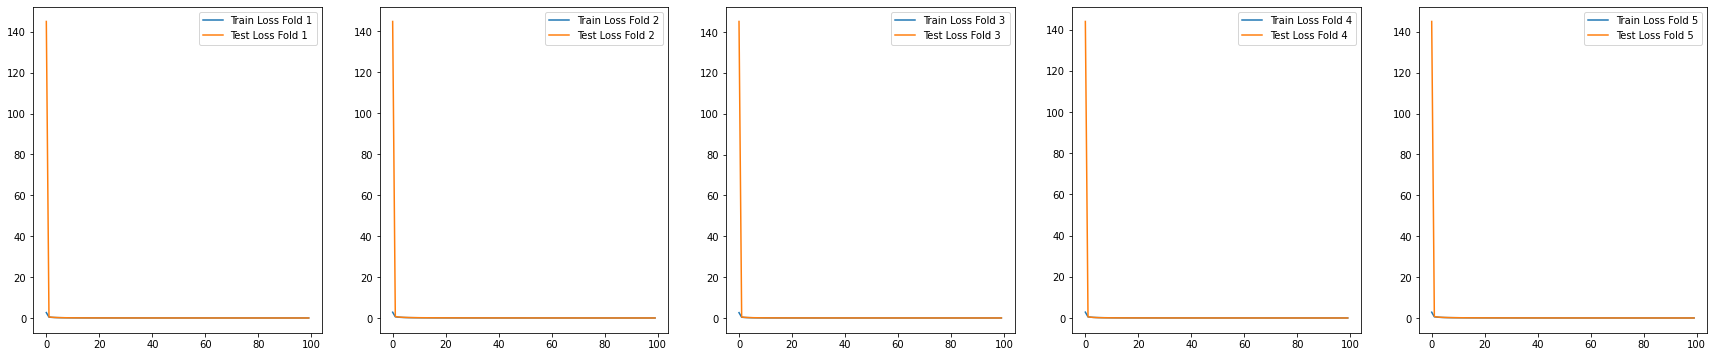

In [13]:


plt.figure(figsize=(30, 6))
for i in range(n_splits):
    plt.subplot(1, n_splits, i+1)
    plt.plot(train_losses_per_fold[i], label=f"Train Loss Fold {i+1}")
    plt.plot(test_losses_per_fold[i], label=f"Test Loss Fold {i+1}")
    plt.legend()
plt.show()

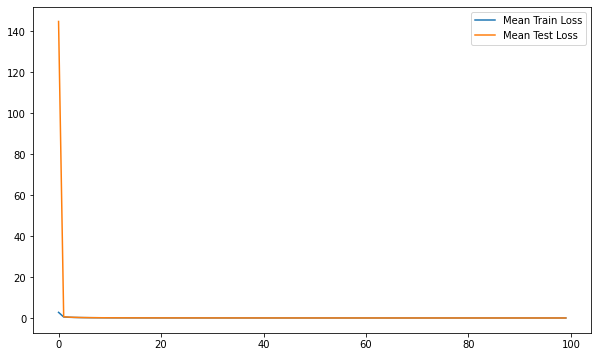

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(mean_train_losses, label="Mean Train Loss")
plt.plot(mean_test_losses, label="Mean Test Loss")
plt.legend()
plt.show()

In [15]:
print("The most possible score is ",np.sqrt(mean_test_losses[-1]))

The most possible score is  0.1868468377588689


In [16]:
with torch.no_grad():
    preds = model.forward(test_features).squeeze()

In [17]:
print("preds.shape: ", preds.shape)
print("preds[:10]: ", preds[:10])

preds.shape:  torch.Size([1459])
preds[:10]:  tensor([126244.0469, 153957.5625, 193121.6094, 210396.9844, 180728.0469,
        191816.7031, 174210.2500, 192006.7656, 187974.1562, 125622.3281])


In [18]:
with torch.no_grad():
    train_preds = model.forward(train_features).squeeze()
print("train_preds[:10]: \n", train_preds[:10])
print("train_labels[:10]: \n", train_labels[:10])

train_preds[:10]: 
 tensor([216511.2344, 181882.6406, 218700.2656, 164026.1719, 255662.9844,
        156787.0469, 238067.4531, 199913.8750, 131320.5000, 116161.3281])
train_labels[:10]: 
 tensor([[208500.],
        [181500.],
        [223500.],
        [140000.],
        [250000.],
        [143000.],
        [307000.],
        [200000.],
        [129900.],
        [118000.]])


In [19]:
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission_no_nn.csv', index=False)